In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

import os
from pathlib import Path

import pylab 
import scipy.stats as stats
import neurokit2 as nk

from ..ecg_features import *
from ..eda_features import *
from ..respiration_features import *

# Loading the data 

In [2]:
path_data = "../Dataset/Physiological/"

filelist= [f for f_sub in [f_names for root,d_names,f_names in os.walk(path_data)] for f in f_sub]
dirlist= [d for d_sub in [d_names for root,d_names,f_names in os.walk(path_data)] for d in d_sub]

data_ecg = dict()
data_eda = dict()
data_rsp = dict()

filelist.sort()

for i in filelist:
    if not i.startswith('.'):
        path = os.path.join(path_data,i.split('_')[0]+'/')
        file = pd.read_csv(path+i, sep=",")
        if file.isnull().sum().sum() != 0:
            print('There are ', file.isnull().sum().sum(), ' nan values in the recording', i)

        file_ecg = np.array(file['ECG'])
        file_eda = np.array(file['EDA'])
        file_rsp = np.array(file['RR'])

        data_ecg[i.split('.')[0]] = (file_ecg - file_ecg.mean())/file_ecg.std()
        data_eda[i.split('.')[0]] = (file_eda - file_eda.mean())/file_eda.std()
        data_rsp[i.split('.')[0]] = (file_rsp - file_rsp.mean())/file_rsp.std()
            
print('There are {0:2d} subjects, and {1:3d} trials in total'.format(len(dirlist), len(filelist)))

There are 65 subjects, and 792 trials in total


In [3]:
data_eda['r5s8_Counting3']

array([nan, nan, nan, ..., nan, nan, nan])

In [4]:
del data_eda['r5s8_Counting3']

# Noise removal and preprocessing using Neurokit2

In [5]:
ecg_clean = data_ecg.copy()
eda_clean = data_eda.copy()
rsp_clean = data_rsp.copy()

for ecg,eda,rsp in zip(data_ecg.items(), data_eda.items(), data_rsp.items()):
    ecg_clean[ecg[0]] = nk.ecg_clean(ecg[1], sampling_rate=500, method="biosppy")
    eda_clean[eda[0]] = nk.eda_clean(eda[1], sampling_rate=500,method='biosppy')
    rsp_clean[rsp[0]] = nk.rsp_clean(rsp[1], sampling_rate=500, method="biosppy")

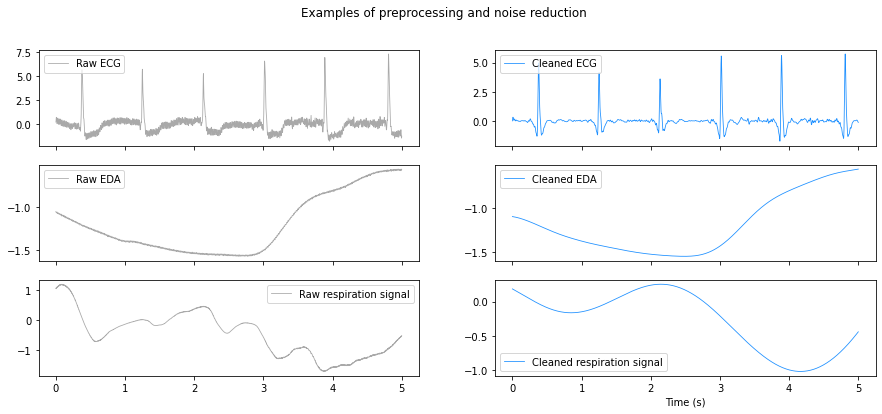

In [6]:
x = np.linspace(0, 5, 2500)

fig, ax = plt.subplots(3,2, figsize=(15, 6), sharex=True)
fig.suptitle('Examples of preprocessing and noise reduction')
ax[0,0].plot(x,list(data_ecg.values())[0][:2500], color = "darkgray", linewidth=0.8, label="Raw ECG")
ax[0,0].legend()
ax[0,1].plot(x,list(ecg_clean.values())[0][:2500], color = "dodgerblue", linewidth=0.8, label="Cleaned ECG")
ax[0,1].legend()
ax[1,0].plot(x,list(data_eda.values())[0][:2500], color = "darkgray", linewidth=0.8, label="Raw EDA")
ax[1,0].legend()
ax[1,1].plot(x,list(eda_clean.values())[0][:2500], color = "dodgerblue", linewidth=0.8, label="Cleaned EDA")
ax[1,1].legend()
ax[2,0].plot(x, list(data_rsp.values())[0][:2500], color = "darkgray", linewidth=0.8, label="Raw respiration signal")
ax[2,0].legend()
ax[2,1].plot(x, list(rsp_clean.values())[0][:2500], color = "dodgerblue", linewidth=0.8, label="Cleaned respiration signal")
ax[2,1].legend()
plt.xlabel('Time (s)')
plt.show()

# Feature extraction

In [7]:
df_eda_features = get_eda_features(eda_clean, 500)
print('EDA: {0:2d} trials and {1:2d} features'.format(df_eda_features.shape[0], df_eda_features.shape[1]))
df_eda_features.head()

EDA: 773 trials and 24 features


,max_eda,min_eda,mean_eda,sd_eda,ku_eda,sk_eda,median_eda,dynrange,scl_slope,max_scr,...,min_scl,mean_scl,sd_scl,nSCR,aucSCR,meanAmpSCR,maxAmpSCR,meanRespSCR,sumAmpSCR,sumRespSCR
2ea4_Baseline,1.857038,-1.550639,1.073381e-04,0.994738,-1.220827,0.367674,-0.323807,-1.197595,-0.023886,0.802275,...,-1.132743,0.022668,0.891539,10.000000,-302.978934,0.666899,1.475682,1.160000,6.668994,11.600000
2ea4_Breathing,2.792216,-1.020082,-3.898045e-07,0.997300,-0.484053,0.861551,-0.349359,-2.737248,-0.015164,1.322088,...,-0.968230,-0.006435,0.951185,7.333333,120.038332,0.651699,1.748524,1.126095,4.779126,7.882667
2ea4_Counting1,0.812062,-2.569678,-1.111397e-04,0.995607,-0.173011,-0.997763,0.537882,-0.316017,0.000323,1.021961,...,-2.159093,0.012778,0.827482,7.000000,-92.589522,0.860715,2.091642,2.433429,6.025006,17.034000
2ea4_Counting2,1.379208,-1.345812,-7.029754e-05,0.998110,-1.478791,0.280679,-0.224129,-1.024815,-0.045947,0.815601,...,-1.167276,-0.011765,0.937448,6.000000,315.591734,0.543249,1.502306,1.810000,3.259493,10.860000
2ea4_Counting3,2.030439,-1.758828,1.097122e-04,0.993741,-1.100469,-0.119663,0.181287,-1.154428,-0.048026,1.225112,...,-1.494708,-0.015553,0.904099,12.000000,558.708830,0.721123,1.743292,1.282167,8.653481,15.386000


In [8]:
df_eda_features.to_csv('Features/eda_features.csv', sep=",", index=True)

In [9]:
df_rsp_features = get_resp_features(rsp_clean, 500)
print('Respiration : {0:2d} trials and {1:2d} features'.format(df_rsp_features.shape[0], df_rsp_features.shape[1]))
df_rsp_features.head()

Respiration : 774 trials and 62 features


,meanRR,minRR,maxRR,sdRR,modeRR,nBB,meanBB,SDSDb,CVNNb,SDNNb,...,VHF_rsp,LF/HF_rsp,rLF_rsp,rHF_rsp,peakLF_rsp,peakHF_rsp,SD1_rrv,SD2_rrv,SD1SD2_rrv,apEn_rrv
2ea4_Baseline,12.375599,8.396306,19.342360,3.391862,10.946054,10.0,5192.600000,2310.027502,1285.815554,0.247625,...,2.403554,1.025407,50.627207,49.372793,0.131387,0.175182,816.718056,333.265493,2.450653,0.105361
2ea4_Breathing,11.569522,6.207325,19.144863,3.719331,12.937538,10.0,5748.333333,3167.215790,1838.581706,0.319846,...,9.995773,2.720270,73.120232,26.879768,0.117188,0.164062,1119.779881,647.574415,1.729191,0.013791
2ea4_Counting1,11.709534,7.425743,17.113520,3.161034,9.687777,10.0,5489.800000,1618.345139,1402.634222,0.255498,...,0.924921,2.623690,72.403819,27.596181,0.082192,0.164384,572.171411,807.847483,0.708267,0.105361
2ea4_Counting2,11.188331,8.415147,17.006803,2.341337,8.591655,10.0,5566.800000,1436.957004,1004.422302,0.180431,...,0.290207,14.867558,93.697833,6.302167,0.081633,0.163265,508.041021,532.339491,0.954355,0.105361
2ea4_Counting3,11.741558,6.600660,16.465423,3.368158,9.864763,10.0,5580.400000,2658.243549,1694.508259,0.303654,...,1.416811,24.370132,96.058357,3.941643,0.084507,0.169014,939.831020,798.010381,1.177718,0.105361


In [10]:
df_rsp_features.to_csv('Features/resp_features.csv', sep=",", index=True)

In [11]:
df_ecg_features = get_ecg_features(ecg_clean, 500)
print('ECG : {0:2d} trials and {1:2d} features'.format(df_ecg_features.shape[0], df_ecg_features.shape[1]))
df_ecg_features.head()

ECG : 774 trials and 46 features


,meanHR,minHR,maxHR,sdHR,modeHR,nNN,meanNN,SDSD,CVNN,SDNN,...,LF/HF,rLF,rHF,peakLF,peakHF,SD1,SD2,SD1SD2,apEn,sampEn
2ea4_Baseline,63.430940,57.034221,79.575597,4.686314,22.541376,62.000000,950.677419,42.033401,64.843179,0.068207,...,0.472074,32.068632,67.931368,0.106195,0.176991,14.861051,43.371318,0.342647,0.011539,0.013870
2ea4_Breathing,61.712465,45.871560,84.269663,11.008515,38.398103,59.666667,1002.893855,106.659486,173.316531,0.172816,...,0.036586,3.529484,96.470516,0.140625,0.171875,37.709823,116.717484,0.323086,0.001829,0.006495
2ea4_Counting1,70.973331,58.365759,82.872928,5.449003,24.507169,69.000000,850.550725,42.532503,67.609179,0.079489,...,0.350256,25.939943,74.060057,0.107143,0.214286,15.037511,45.417179,0.331097,0.002902,0.028731
2ea4_Counting2,64.301154,56.285178,79.787234,5.497478,23.502056,63.000000,939.587302,58.359502,76.110328,0.081004,...,0.237192,19.171814,80.828186,0.106195,0.318584,20.633200,49.781578,0.414475,0.007508,0.018843
2ea4_Counting3,66.253133,55.762082,80.645161,5.443261,24.883080,65.000000,911.661538,42.853573,74.014193,0.081186,...,1.676766,62.641481,37.358519,0.106195,0.176991,15.151026,49.358659,0.306958,0.003383,0.022473


In [12]:
df_ecg_features.to_csv('Features/ecg_features.csv', sep=",", index=True)

#### All features

In [13]:
df_features = pd.concat([df_ecg_features, df_rsp_features], axis=1)
print(df_features.shape)

(774, 108)


In [14]:
df_features = df_features.merge(df_eda_features, left_index= True, right_index=True)
print(df_features.shape)

(773, 132)


In [15]:
nan_cols = [i for i in df_features.columns if df_features[i].isnull().sum() > 0.2 * len(df_features)]
nan_cols

[]

In [16]:
df_features.to_csv('Features/all_physiological_features.csv', sep=",", index=True)